TODO LONG-TERM
* Complete function documentation.
* Jail strategy is hard-coded as, in order, use a Get-Out-Of-Jail card, pay the fine, and roll the dice. In the future, strategy selection should be able to vary across players and be context-sensitive.
* Default method is simplistic. Need to code logic for what happens to defaulter's property.

### Import modules

In [137]:
# To be removed later
import time

# General
import numpy as np
import pandas as pd
import random

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook

### Make declarations

In [149]:
VERBOSE = False
#VERBOSE = True

### Define functions

In [151]:
def get_players(n_players):
        
    assert n_players > 2, 'A game must have at least 2 players.'
    assert n_players < 8, 'A game must have no more than 8 players.'
    
    class Player(object):
        
        def __init__(self, player_id):
            self.id = player_id  # Identification number
            self.cash = 1500     # Cash on hand
            self.properties = [] # List of properties
            self.position = 0    # Board position
            self.jail_cards = 0  # Number of "Get Out Of Jail Free" cards
            self.jail_turns = 0  # Number of remaining turns in jail
            self.jail_strtg = '' # Jail strategy
            self.buy_strategy = 1
            self.bankrupt = False
            self.bankrupt_game_round = None
        
        def move(self, roll):
            self.position += roll
            passed_go = False
            if self.position >= 40:
                self.position -= 40
                self.cash += 200
                passed_go = True
            if VERBOSE:
                if passed_go:
                    print('Player %d from position %d to %d passing go (Cash now: %d)' %
                          (self.id, self.position - roll, self.position, self.cash))
                else:
                    print('Player %d from position %d to %d' %
                          (self.id, self.position - roll, self.position))
        
        def evaluate_buy(self, prop):
            prop_has_owner = prop.owner is not None
            prop_is_mine = False
            if prop_has_owner and prop.owner == self.id:
                prop_is_mine = True

            # Landed on somebody else's property
            if prop_has_owner and prop_is_mine == False:
                # Pay the rent
                self.bankrupt = self.pay(players[prop.owner], prop)
                return

            # Landed on my property
            if prop_has_owner and prop_is_mine == True:
                if type(prop).__name__ == "Street" and self.buy_strategy == 1:
                    # This property is a street. See, if can build.
                    self_can_afford = self.cash >= prop.price_building
                    if self_can_afford:
                        self.build(prop)

                # No-op, no need to pay to self
                return

            # Landed on unowned property
            if self.buy_strategy == 1:
                # Greedy, buy all!
                self_can_afford = self.cash >= prop.price
                if self_can_afford:
                    self.buy(prop)
        
        def evaluate_build(self):
            # Create a way to let players know when they have a monopoly
            # Create a way also of letting players know how many buildings they have
            # The second is a little tougher because you have to build them in a certain order
            # At first, just choose randomly
            # Then, they can start building their hotels as soon as they can
            pass
        
        def buy(self, prop):
            self.properties.append(prop.position)
            self.cash -= prop.price
            prop.owner = self.id
            if VERBOSE:
                print('Player %d bought %s (Price: %d, Cash now: %d)' %
                      (self.id, prop.name, prop.price, self.cash))

        def build(self, prop):
            if prop.building_cnt == 5:
                return

            self.cash -= prop.price_building
            prop.rent_now = prop.rent_building[prop.building_cnt]
            prop.building_cnt += 1
            if VERBOSE:
                print('Player %d built a house %s (Price: %d, Cash now: %d)' %
                      (self.id, prop.name, prop.price, self.cash))
        
        def pay(self, other, prop):
            payment = prop.rent_now
            if payment > self.cash:
                if VERBOSE:
                    print('Player %d cannot pay $%d to Player %d (Payment: %d, Cash now: %d)' %
                          (self.id, payment, other.id, payment, self.cash))
                return True
            self.cash -= payment
            other.cash += payment
            if VERBOSE:
                print('Player %d paid $%d (%s) to Player %d (Cash now: %d)' %
                      (self.id, payment, prop.name, other.id, self.cash))
            return False

        def go_to_jail(self):
            self.position = 10
            self.jail_turns = 3
            if VERBOSE:
                print('Player %d goes to jail' % (self.id))
        
        def choose_jail_strtg(self, rolled_double):
            if self.jail_cards > 0:
                self.jail_strtg = 'card'
                self.jail_turns = 0
                self.jail_cards -= 1
            elif self.cash >= 50:
                self.jail_strtg = 'pay'
                self.jail_turns = 0
                self.cash -= 50
            else:
                self.jail_strtg = 'roll'
                if rolled_double:
                    self.jail_turns = 0
                else:
                    self.jail_turns -= 1
                    if self.jail_turns == 0:
                        self.cash -= 50
            if VERBOSE:
                print('Player %d took jail strategy %s and has %d jail turns left' %
                      (self.id, self.jail_strtg, self.jail_turns))
                        
        def default(self):
            del players[self.id]
            
    return [Player(p) for p in range(n_players)]

In [87]:
def get_board(board_file):

    class Property(object):
        def __init__(self, name, position, price, rent):
            self.name = name
            self.position = position
            self.price = price
            self.price_mortgage = price / 2
            self.rent = rent
            self.rent_now = rent
            self.mortgage = False
            self.owner = None

    class Street(Property):
        def __init__(self, name, position, color, price, price_building, rent, rent_building, size_monopoly):
            Property.__init__(self, name, position, price, rent)
            self.color = color
            self.price_building = price_building
            self.rent_monopoly = rent * 2
            self.rent_building = rent_building
            self.size_monopoly = size_monopoly
            self.building_cnt = 0

    class Railroad(Property):
        def __init__(self, name, position, price, rent):
            Property.__init__(self, name, position, price, rent)
            self.rent_double = rent * 2
            self.rent_triple = self.rent_double * 2
            self.rent_monopoly = self.rent_triple * 2
            self.size_monopoly = 4
    
    class Utility(Property):
        def __init__(self, name, position, price, rent):
            Property.__init__(self, name, position, price, rent)
            self.rent_monopoly = rent + 6
            self.size_monopoly = 2
    
    class Tax(object):
        def __init__(self, price):
            self.price = price

    class Card(object):
        pass  
    
    class Chance(object):
        pass
    
    class Chest(object):
        pass
    
    class Jail(object):
        pass
    
    class Idle(object):
        pass
    
    board = []
    
    for _, r in pd.read_csv(board_file).iterrows():
        for case in switch(r['class']):
            if case('Street'):
                board.append(Street(r['name'], r['position'], r['monopoly'],
                                    r['price'], r['build_cost'], r['rent'],
                                    [r['rent_house_1'], r['rent_house_2'], r['rent_house_3'],
                                     r['rent_house_4'], r['rent_hotel']],
                                    r['monopoly_size']))
            elif case('Railroad'):
                board.append(Railroad(r['name'], r['position'], int(r['price']), int(r['rent'])))
            elif case('Utility'):
                board.append(Utility(r['name'], r['position'], int(r['price']), int(r['rent'])))
            elif case('Tax'):
                board.append(Tax(int(r['tax'])))
            elif case('Chance'):
                board.append(Chance())
            elif case('Chest'):
                board.append(Chest())
            elif case('Jail'):
                board.append(Jail())
            elif case('Idle'):
                board.append(Idle())
    
    return board

In [69]:
def roll_dice(check_double=True):

    roll = np.random.choice(np.arange(1, 7), 2)
    
    if VERBOSE:
        print('Die roll: %d and %d' % (roll[0], roll[1]))
    
    if check_double:
        return roll.sum(), roll[0] == roll[1]
    else:
        return roll.sum()

In [70]:
class switch(object):
    
    def __init__(self, value):
        self.value = value
        self.fall = False

    def __iter__(self):
        """Return the match method once, then stop"""
        yield self.match
        raise StopIteration
    
    def match(self, *args):
        """Indicate whether or not to enter a case suite"""
        if self.fall or not args:
            return True
        elif self.value in args:
            self.fall = True
            return True
        else:
            return False

### Play the game

<IPython.core.display.Javascript object>


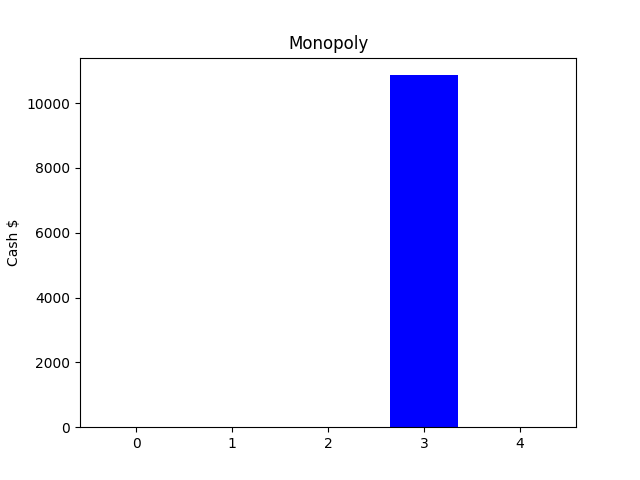

Begin game round: 1 with 5 active players
Begin game round: 2 with 5 active players
Begin game round: 3 with 5 active players
Begin game round: 4 with 5 active players
Begin game round: 5 with 5 active players
Begin game round: 6 with 5 active players
Begin game round: 7 with 5 active players
Begin game round: 8 with 5 active players
Begin game round: 9 with 5 active players
Begin game round: 10 with 5 active players
Begin game round: 11 with 5 active players
Begin game round: 12 with 5 active players
Begin game round: 13 with 5 active players
Begin game round: 14 with 5 active players
Begin game round: 15 with 5 active players
Begin game round: 16 with 5 active players
Begin game round: 17 with 5 active players
Begin game round: 18 with 5 active players
Begin game round: 19 with 5 active players
Begin game round: 20 with 5 active players
Begin game round: 21 with 5 active players
Begin game round: 22 with 5 active players
Begin game round: 23 with 5 active players
Begin game round: 24

In [153]:
# Declarations
n_players = 5
board_file = 'board.csv'

# Get players and board (including properties)
players = get_players(n_players)
board = get_board(board_file)
active_players = len(players)

# Start on round 1
game_round = 1

# Create figure and axis objects
fig, ax = plt.subplots(1, 1)
ax.set_title("Monopoly")
ax.set_ylabel('Cash $')
ind = np.arange(n_players)
colors = ['r', 'g', 'b', '#F58322', '#FFF500', '#8D2C87', '#FCB71E', '#1EB7B2']
random.shuffle(colors)
colors = colors[:n_players]
bars = None

# Draw barplot
bars = ax.bar(ind, cashes, 0.7, color=colors)
fig.canvas.draw()

# Start game
while active_players > 1:
    
    print("Begin game round: %d with %d active players" % (game_round, active_players))

    # Take turns
    for turn in range(n_players):
        # End of game -rule: If there is only one player left, there is no point of playing.
        if active_players == 1:
            break

        # Define current player
        curr_player = players[turn]
        if curr_player.bankrupt:
            if VERBOSE:
                print("Player %d is bankrupt, skipping" % turn)
            continue

        # Double roll counter
        n_double_roll = 0

        # Continue turn until player rolls no doubles or goes to jail
        while True:

            # Roll dice
            roll, rolled_double = roll_dice()

            # Update double roll counter
            n_double_roll += (rolled_double).astype(int)

            # If player is in jail
            if players[turn].jail_turns > 0:

                # Select jail strategy
                curr_player.choose_jail_strtg(rolled_double)

                # If player is still in jail
                if curr_player.jail_turns > 0:
                    break

            # If player rolled less than 3 doubles
            if n_double_roll < 3:

                # Move player 
                curr_player.move(roll)
                
                # Define current board space
                curr_space = board[curr_player.position]
                                
                for case in switch(type(curr_space).__name__):
                    if case('Street') or case('Railroad') or case('Utility'):
                        curr_player.evaluate_buy(curr_space)

                # No more cash?
                if curr_player.bankrupt:
                    print("Noooooooooo! Player %d went bankrupt." % turn)
                    active_players -= 1
                    curr_player.bankrupt_game_round = game_round
                    # ToDo: Release any property the player had
                    break

                # If no double rolled, end turn
                if not rolled_double:
                    break

            # Otherwise, send player to jail and end turn
            elif n_double_roll == 3:
                                
                curr_player.go_to_jail()
                break

            # Now here is where we start interacting with the board
            type(board[4]).__name__

    game_round += 1
    
    # Update graph data
    cashes = []
    for turn in range(n_players):
        cash = players[turn].cash
        if players[turn].bankrupt:
            cash = 0
        cashes.append(cash)
    
    # Draw updated graph
    if bars:
        bars.remove()
        bars = None
    bars = ax.bar(ind, cashes, 0.7, color=colors)
    fig.canvas.draw()

    # Assume, that if game hasn't finished in 500 rounds, there is a bug.
    if game_round == 500:
        break

# Declare winner
winner = None
for turn in range(n_players):
    if players[turn].bankrupt:
        continue
    winner = turn
if winner is not None:
    print("Player %d wins! Has $%d at the end" % (winner, players[winner].cash))
else:
    print("Nobody won")